# Telecom Churn Prediction | Neural Network Classifier

## Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Load preprocessed data

In [2]:
df_preprocessed = pd.read_csv('../data/processed/preprocessed_telco.csv')

In [3]:
df_preprocessed.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0.013889,0.115423,0.003437,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0.472222,0.385075,0.217564,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.027778,0.354229,0.012453,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0.625000,0.239303,0.211951,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.027778,0.521891,0.017462,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


## Independent and Dependent variables

In [4]:
X = df_preprocessed.drop('Churn_Yes', axis=1)
y = df_preprocessed['Churn_Yes']

In [5]:
y.value_counts()

Churn_Yes
0    5174
1    1869
Name: count, dtype: int64

## Converting data to numpy arrays

In [6]:
X = X.values
y = y.values

## Train Test Split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 30)
(1409, 30)
(5634,)
(1409,)


## Hanlde class imbalance 

In [9]:
from sklearn.utils import class_weight

In [10]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

In [11]:
class_weights_dict = dict(enumerate(class_weights))

## Neural Network Model

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(32, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\sanid\VS Projects\Telecom_Churn_Prediction\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [14]:
model.compile(
    optimizer=optimizer,
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [16]:
history = model.fit(
    x_train,
    y_train, 
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6909 - auc: 0.6132 - loss: 0.6987 - val_accuracy: 0.7320 - val_auc: 0.7806 - val_loss: 0.6061
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7580 - auc: 0.8182 - loss: 0.6038 - val_accuracy: 0.7028 - val_auc: 0.8005 - val_loss: 0.5686
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7398 - auc: 0.8338 - loss: 0.5397 - val_accuracy: 0.7054 - val_auc: 0.8090 - val_loss: 0.5726
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7398 - auc: 0.8291 - loss: 0.5413 - val_accuracy: 0.7081 - val_auc: 0.8121 - val_loss: 0.5760
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7493 - auc: 0.8452 - loss: 0.5163 - val_accuracy: 0.7178 - val_auc: 0.8144 - val_loss: 0.5555
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7519 - auc: 0.8472 - loss: 0.5196 - val_accuracy: 0.7196 - val_auc: 0.8157 - val_loss: 0.5565
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluate the Model

### Plot loss

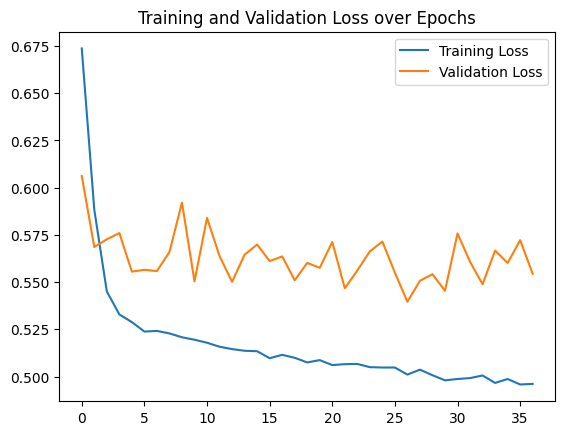

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

### Test Accuracy

In [18]:
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7503 - auc: 0.8335 - loss: 0.5283
Test Accuracy: 0.7488, Test AUC: 0.8378


In [19]:
y_pred_prob = model.predict(x_test)

y_pred = (y_pred_prob > 0.5).astype(int)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


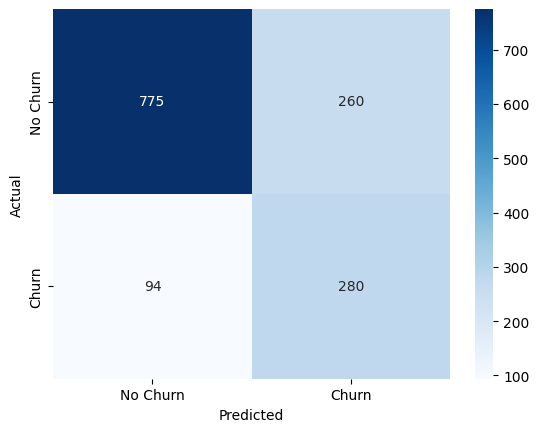

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Plot ROC Curve

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
ROC-AUC score: 0.8376837427988324


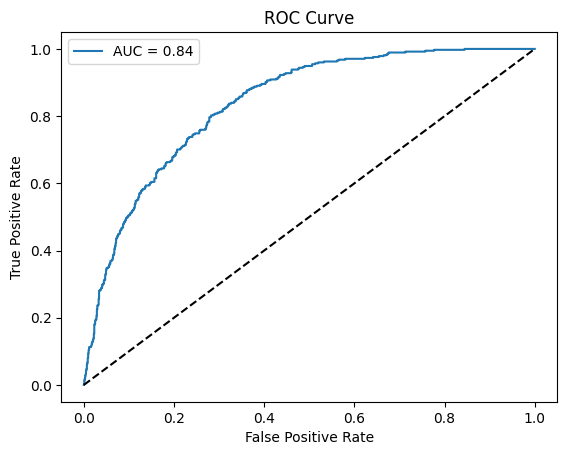

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_prob = model.predict(x_test)
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC score:", auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## Tuning the Model

Performing Hyperparameter tuning with keras-tuner

In [22]:
import keras_tuner as kt

In [23]:
def build_model(hp):
    model = tf.keras.Sequential()

    hp_layer_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    hp_layer_2 = hp.Int('units_2', min_value=16, max_value=256, step=32)
    hp_layer_3 = hp.Int('units_3', min_value=16, max_value=128, step=16)
    hp_activation = hp.Choice('activation', values=['relu', 'selu', 'tanh', 'gelu'])
    hp_l2 = hp.Float('l2_regularization', min_value=1e-6, max_value=1e-3, sampling='LOG')
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.3, step=0.05)
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
    hp_label_smoothing = hp.Float('label_smoothing', min_value=0.0, max_value=0.3, step=0.05)


    model.add(tf.keras.layers.InputLayer(input_shape=(x_train.shape[1],)))

    model.add(tf.keras.layers.Dense(
        hp_layer_1,
        activation=hp_activation,
        kernel_regularizer=tf.keras.regularizers.l2(hp_l2)
    ))

    model.add(tf.keras.layers.Dropout(hp_dropout))

    model.add(tf.keras.layers.Dense(
        hp_layer_2,
        activation=hp_activation,
        kernel_regularizer=tf.keras.regularizers.l2(hp_l2)
    ))

    model.add(tf.keras.layers.Dropout(hp_dropout))

    model.add(tf.keras.layers.Dense(
        hp_layer_3,
        activation=hp_activation,
        kernel_regularizer=tf.keras.regularizers.l2(hp_l2)
    ))

    model.add(tf.keras.layers.Dropout(hp_dropout))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=hp_label_smoothing)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    return model

In [24]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband_tuning',
    project_name='telco_churn_nn'
)

c:\Users\sanid\VS Projects\Telecom_Churn_Prediction\.venv\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [26]:
tuner.search(
    x_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[stop_early]
)

Trial 90 Complete [00h 00m 08s]
val_accuracy: 0.7488908767700195

Best val_accuracy So Far: 0.7613131999969482
Total elapsed time: 00h 09m 10s


## Get the Top 5 Models

In [27]:
top_n = 5
top_models = tuner.get_best_models(num_models=top_n)
top_hps = tuner.get_best_hyperparameters(num_trials=top_n)
trained_models = []
histories = []

In [28]:
for i, hp in enumerate(top_hps):
    model = tuner.hypermodel.build(hp)

    history = model.fit(
        x_train,
        y_train,
        epochs=50,
        validation_split=0.2,
        class_weight=class_weights_dict,
        callbacks=[stop_early],
        verbose=0
    ) 

    trained_models.append(model)
    histories.append(history)

    print(f"Trained model {i+1} with hyperparameters: {hp.values}")

Trained model 1 with hyperparameters: {'units_1': 64, 'units_2': 176, 'units_3': 112, 'activation': 'selu', 'l2_regularization': 0.00027230671645694796, 'dropout': 0.05, 'learning_rate': 0.0004947210033480447, 'label_smoothing': 0.15000000000000002, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0066'}
Trained model 2 with hyperparameters: {'units_1': 32, 'units_2': 144, 'units_3': 32, 'activation': 'relu', 'l2_regularization': 5.2686603310691054e-06, 'dropout': 0.25, 'learning_rate': 2.2973348593704516e-05, 'label_smoothing': 0.1, 'tuner/epochs': 6, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Trained model 3 with hyperparameters: {'units_1': 256, 'units_2': 112, 'units_3': 96, 'activation': 'tanh', 'l2_regularization': 0.00023289861365834562, 'dropout': 0.2, 'learning_rate': 0.0005224032020999129, 'label_smoothing': 0.2, 'tuner/epochs': 17, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Traine

## Evaluating the top selected models

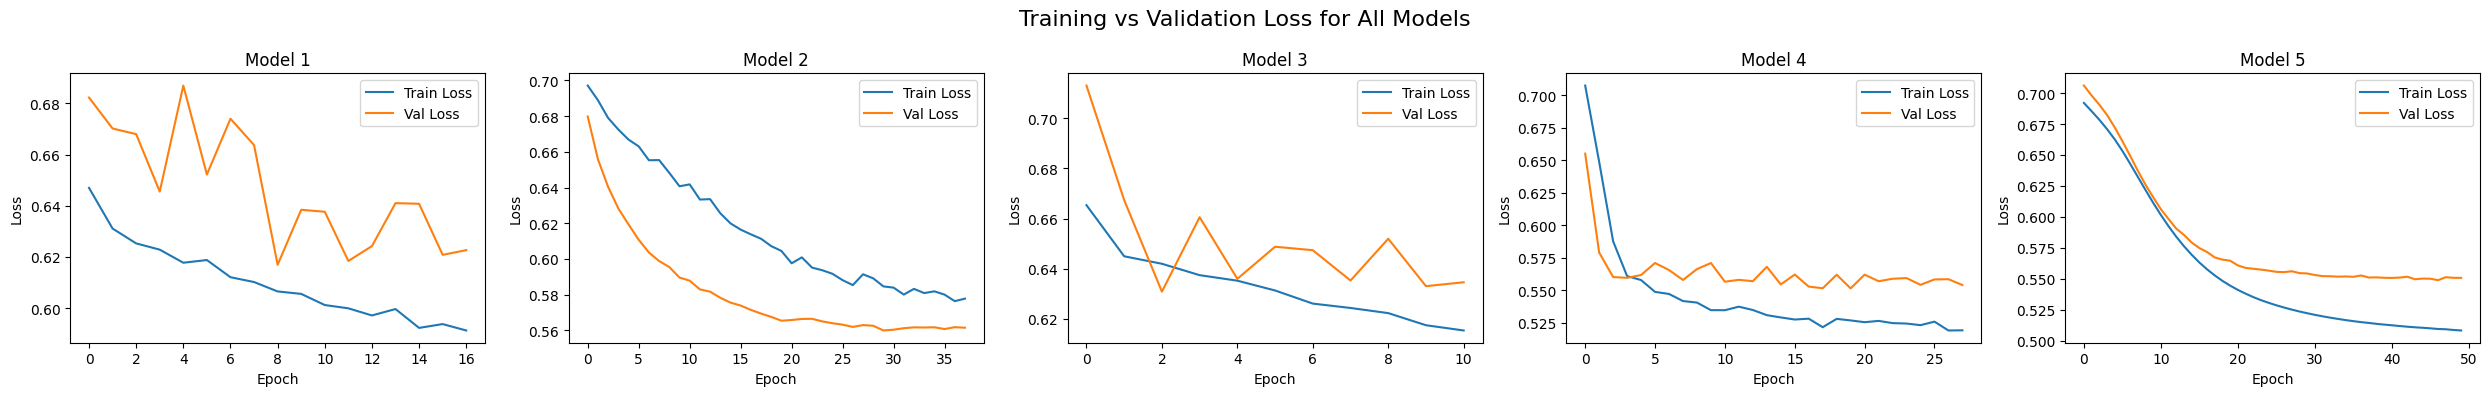

In [44]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, history in enumerate(histories):
    ax = axes[i]
    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Val Loss')
    ax.set_title(f"Model {i+1}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

plt.suptitle("Training vs Validation Loss for All Models", fontsize=16)
plt.tight_layout()
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


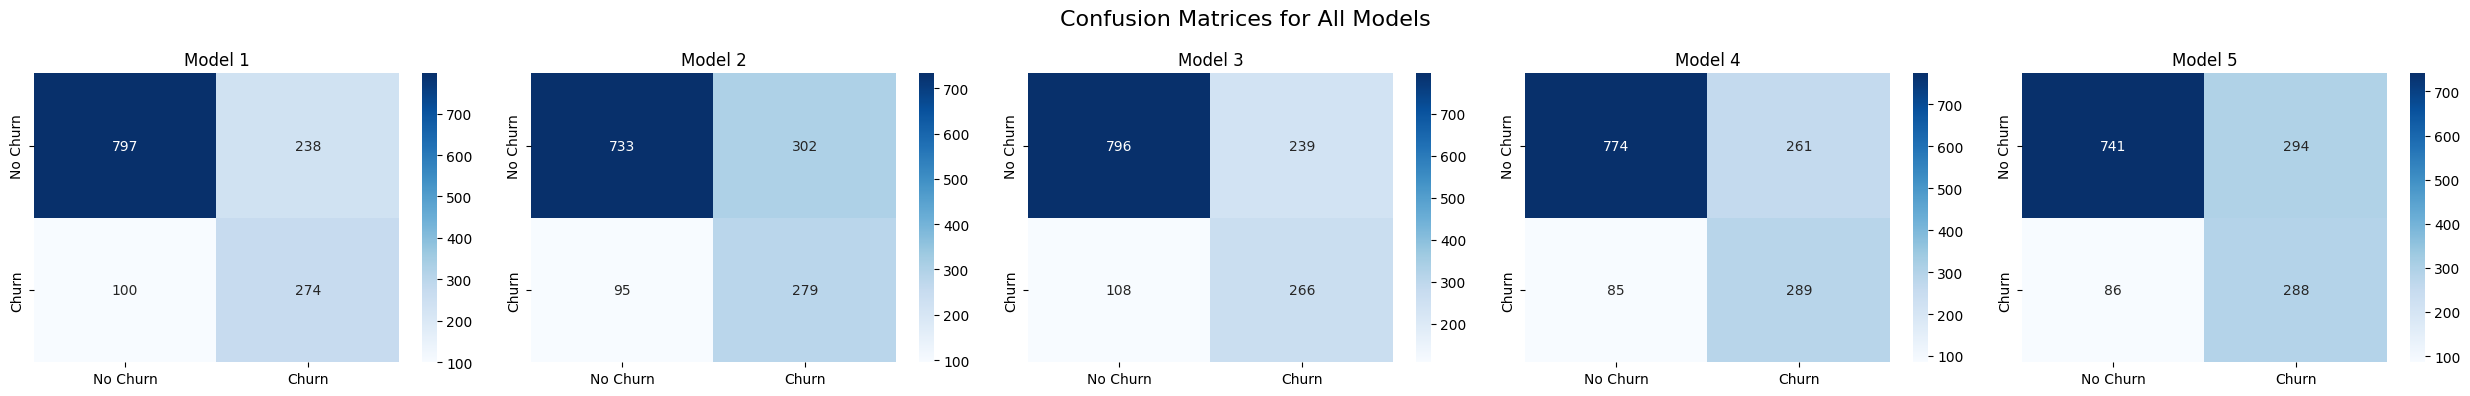

In [45]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, model in enumerate(trained_models):
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'],
                ax=ax)
    ax.set_title(f"Model {i+1}")

plt.suptitle("Confusion Matrices for All Models", fontsize=16)
plt.tight_layout()
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


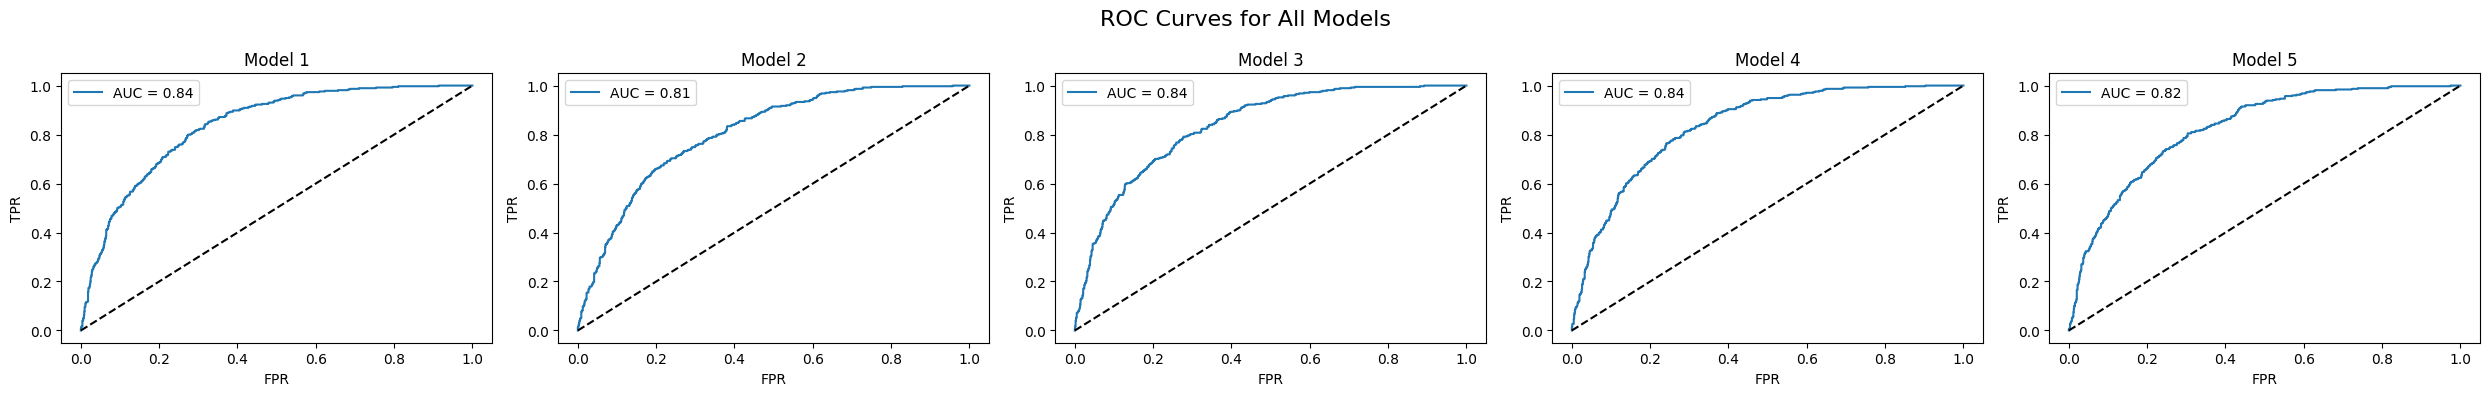

In [46]:
fig, axes = plt.subplots(1, 5, figsize=(25, 4))

for i, model in enumerate(trained_models):
    y_pred_prob = model.predict(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    ax.plot([0,1], [0,1], 'k--')
    ax.set_title(f"Model {i+1}")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend()

plt.suptitle("ROC Curves for All Models", fontsize=16)
plt.tight_layout()
plt.show()


In [48]:
print("Test Accuracy for All Modelsn")

for i, model in enumerate(trained_models):
    test_loss, test_acc, test_auc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Model {i+1}:")
    print(f"  Accuracy = {test_acc:.4f}")
    print(f"  AUC      = {test_auc:.4f}\n")


Test Accuracy for All Modelsn
Model 1:
  Accuracy = 0.7601
  AUC      = 0.8372

Model 2:
  Accuracy = 0.7182
  AUC      = 0.8062

Model 3:
  Accuracy = 0.7537
  AUC      = 0.8358

Model 4:
  Accuracy = 0.7544
  AUC      = 0.8373

Model 5:
  Accuracy = 0.7303
  AUC      = 0.8248



In [ ]:
from sklearn.metrics import classification_report

for i, model in enumerate(trained_models):
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("="*60)
    print(f"               Classification Report — Model {i+1}")
    print("="*60)
    print(classification_report(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
               Classification Report — Model 1
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.73      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
               Classification Report — Model 2
              precision    recall  f1-score   support

           0       0.89      0.71      0.79      1035
           1       0.48      0.75      0.58       374

    accuracy                           0.72      1409
   macro avg       0.68      0.73      0.69      1409
weighted avg       0.78      0.72      0.73      1409

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
               Classification Report — Model 3
              precision    recall  f1-score   support

           0       0.88      0.77

## Summary of the evaluation 

- The model 5 performs really well with generalizing the model, nevertheless, it underperforms when it comes to classification. The confusion matrix proves it. 
- The model 2 does not correctly identify no churners 
- The model 3 and 4 strongly contends to be the best model, but out of them the model 4 slightly outperforms model 3 in ROC score, test accuracy and generalizing

<br>

Therefore a final model selected model will be model 4

## Saving the Best Model

In [56]:
final_model = trained_models[3]

In [57]:
final_model.evaluate(x_test, y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7567 - auc: 0.8349 - loss: 0.5381 


[0.5346896052360535, 0.7544357776641846, 0.8372613191604614]

In [58]:
final_model.save("../model-export/churn_nn_model.keras")